In [79]:
import re
from textstat import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

print(os.getcwd())

/data/Documents/DataScience/Courses/Dissertation/src/evaluation


## Analyse Documentation


In [80]:
def analyze_docs_content(content):
    def clean_rst_content(content):
        content = re.sub(r'::[\s\S]*?\n\n', '', content) # code blocks
        content = re.sub(r'.. [a-z]+::.*?\n', '', content) # rst commands
        content = re.sub(r':[a-z]+:`.*?`', '', content) # inline
        content = re.sub(r'`[^`\n]+`_', '', content) # links
        return content
    cleaned_content = clean_rst_content(content)
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(cleaned_content),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(cleaned_content),
        'smog_index': textstat.smog_index(cleaned_content),
        'automated_readability_index': textstat.automated_readability_index(cleaned_content),
        'difficult_words': textstat.difficult_words(cleaned_content),
    }

In [81]:
def analyze_sphinx_docs(docs_source_dir):
    results = {}
    for root, dirs, files in os.walk(docs_source_dir):
        for file in files:
            if file.endswith('.rst'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                results[file] = analyze_docs_content(content)
    return results

In [82]:
def print_results(results):
    for file_path, metrics in results.items():
        print(f"\nAnalysis for {file_path}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value}")

In [83]:
docs_source_dir = '../../docs/source'
results = analyze_sphinx_docs(docs_source_dir)
print_results(results)


Analysis for api_reference.rst:
  flesch_reading_ease: -46.13
  flesch_kincaid_grade: 21.6
  smog_index: 0.0
  automated_readability_index: 32.2
  difficult_words: 11

Analysis for candidate_generator.rst:
  flesch_reading_ease: -233.77
  flesch_kincaid_grade: 48.1
  smog_index: 0.0
  automated_readability_index: 110.8
  difficult_words: 12

Analysis for config_manager.rst:
  flesch_reading_ease: -121.76
  flesch_kincaid_grade: 32.0
  smog_index: 0.0
  automated_readability_index: 83.7
  difficult_words: 10

Analysis for index.rst:
  flesch_reading_ease: 13.91
  flesch_kincaid_grade: 13.0
  smog_index: 10.5
  automated_readability_index: 33.7
  difficult_words: 12

Analysis for installation.rst:
  flesch_reading_ease: 48.16
  flesch_kincaid_grade: 8.1
  smog_index: 9.4
  automated_readability_index: 15.7
  difficult_words: 20

Analysis for introduction.rst:
  flesch_reading_ease: 7.56
  flesch_kincaid_grade: 17.5
  smog_index: 18.0
  automated_readability_index: 27.2
  difficult_words

In [84]:
avg_scores = {metric: sum(doc[metric] for doc in results.values()) / len(results)
              for metric in next(iter(results.values()))}

print("\nAverage scores across all documents:")
for metric, value in avg_scores.items():
    print(f"  {metric}: {value:.2f}")



Average scores across all documents:
  flesch_reading_ease: -52.06
  flesch_kincaid_grade: 22.92
  smog_index: 7.03
  automated_readability_index: 50.63
  difficult_words: 24.11


In [85]:
df = pd.DataFrame(results)
df.head()

,api_reference.rst,candidate_generator.rst,config_manager.rst,index.rst,installation.rst,introduction.rst,quickstart.rst,synthesis_problem.rst,synthesis_strategy.rst
flesch_reading_ease,-46.13,-233.77,-121.76,13.91,48.16,7.56,42.38,-6.36,-172.52
flesch_kincaid_grade,21.60,48.10,32.00,13.00,8.10,17.50,10.30,16.60,39.10
smog_index,0.00,0.00,0.00,10.50,9.40,18.00,12.30,13.10,0.00
automated_readability_index,32.20,110.80,83.70,33.70,15.70,27.20,18.10,32.10,102.20
difficult_words,11.00,12.00,10.00,12.00,20.00,36.00,60.00,47.00,9.00


In [86]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'Document'}, inplace=True)
df_melted = df.melt(id_vars=['Document'], var_name='Metric', value_name='Score')
df.head()

,Document,api_reference.rst,candidate_generator.rst,config_manager.rst,index.rst,installation.rst,introduction.rst,quickstart.rst,synthesis_problem.rst,synthesis_strategy.rst
0,flesch_reading_ease,-46.13,-233.77,-121.76,13.91,48.16,7.56,42.38,-6.36,-172.52
1,flesch_kincaid_grade,21.60,48.10,32.00,13.00,8.10,17.50,10.30,16.60,39.10
2,smog_index,0.00,0.00,0.00,10.50,9.40,18.00,12.30,13.10,0.00
3,automated_readability_index,32.20,110.80,83.70,33.70,15.70,27.20,18.10,32.10,102.20
4,difficult_words,11.00,12.00,10.00,12.00,20.00,36.00,60.00,47.00,9.00


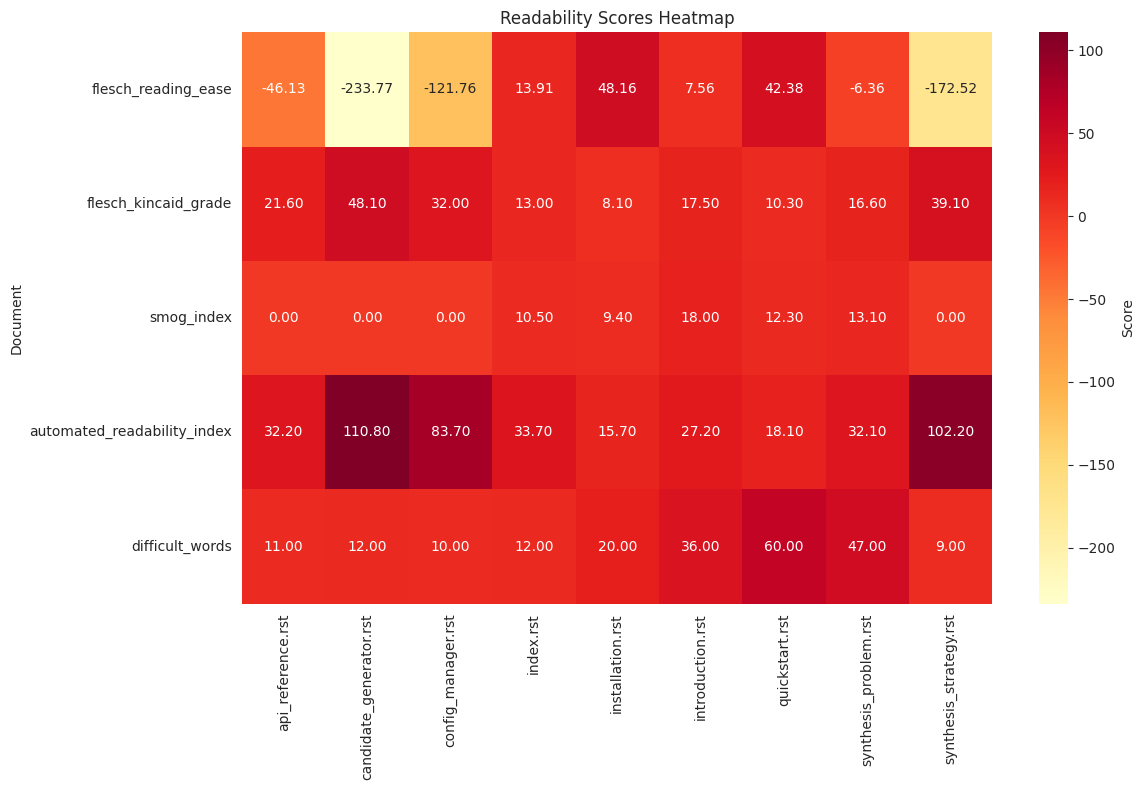

In [91]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.set_index('Document'), cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Score'})
plt.title('Readability Scores Heatmap')
plt.tight_layout()
plt.savefig('readability_heatmap.png')
plt.show()

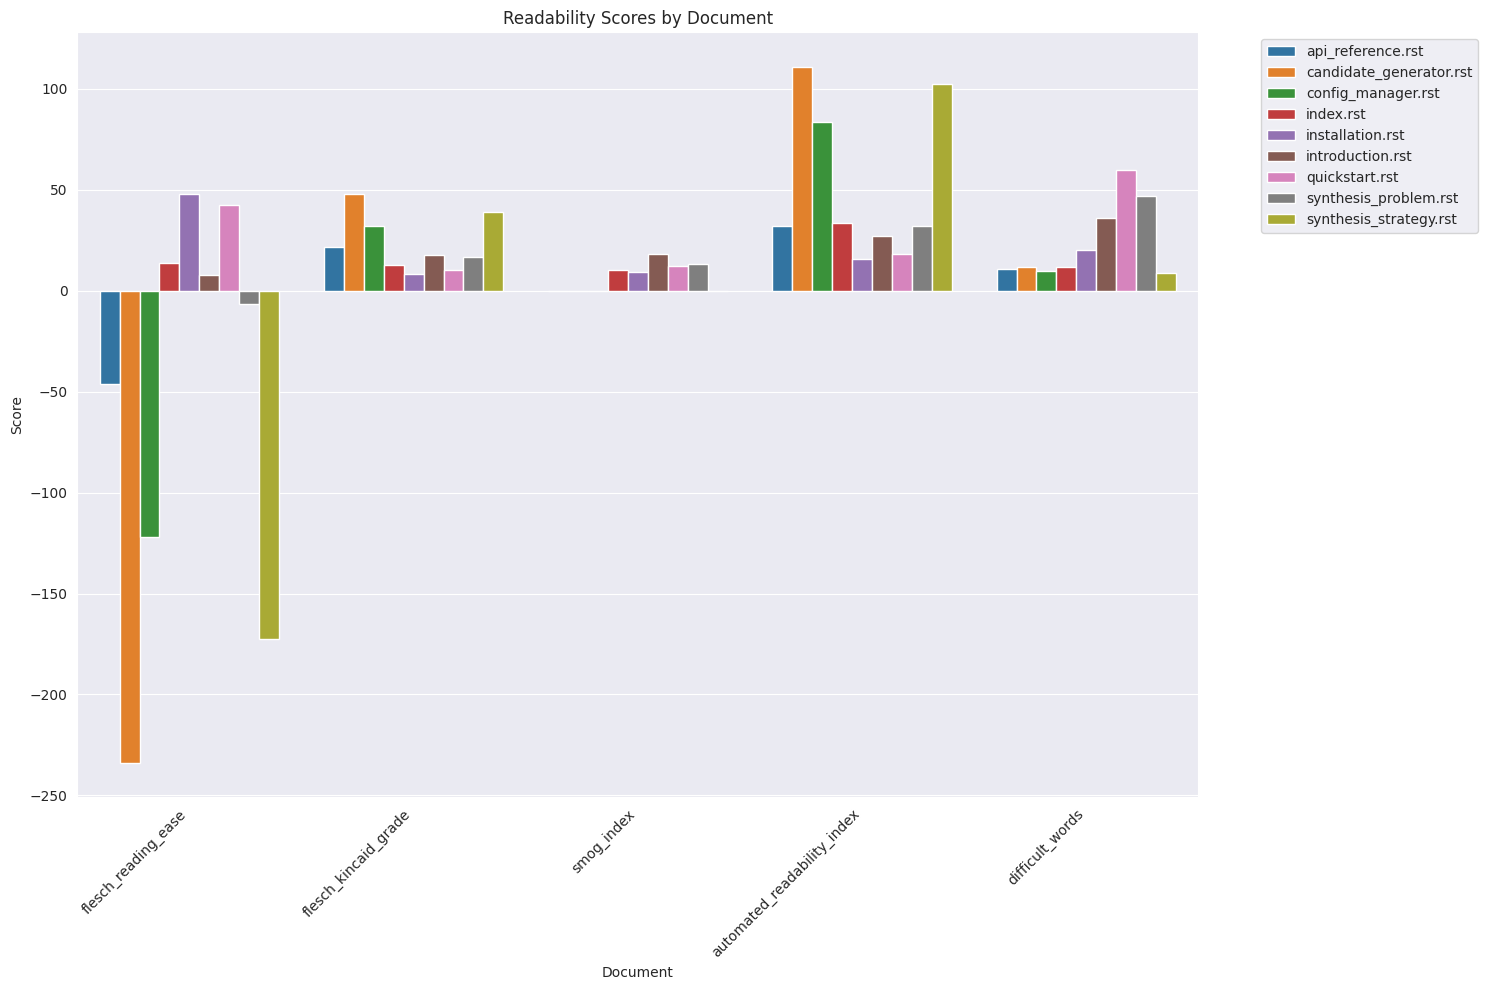

In [92]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Document', y='Score', hue='Metric', data=df_melted)
plt.xticks(rotation=45, ha='right')
plt.title('Readability Scores by Document')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('readability_barplot.png')
plt.show()